<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/learning_tf_transfer_learning_tfrec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports

In [ ]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.4.1


#Configuration

In [ ]:
PATH_PATTERN = '/content/drive/MyDrive/Colab Notebooks/clickbait_detection/root_dataset/tfrec_image_data/tfrecords-jpeg-180x180-nnn/*.tfrec'
IMAGE_SIZE = [180, 180]

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS = 10

VALIDATION_SPLIT = 0.3

CLASSES = [b'clickbaits', b'nonclickbaits'] # do not change, maps to the labels in the data (folder names)


In [ ]:
# splitting data files between training and validation
filenames = tf.io.gfile.glob(PATH_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]

print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))


Pattern matches 16 data files. Splitting dataset into 12 training files and 4 validation files


In [ ]:
validation_steps = int(15335  // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(15335  // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

With a batch size of 64, there will be 179 batches per training epoch and 59 batch(es) per validation run.


In [ ]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

#Read images and labels from TFRecords

In [ ]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

In [ ]:
#@title Train & Validation data visualization 
display_9_images_from_dataset(load_dataset(training_filenames))
display_9_images_from_dataset(load_dataset(validation_filenames))

#training and validation datasets

In [ ]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

#Model

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy','Recall','Precision']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 46080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 46081     
Total params: 2,304,065
Trainable params: 46,081
Non-trainable params: 2,257,984
_________________________________________________________________


#Training

In [ ]:
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=validation_steps)

Epoch 1/10
179/179 [==============================] - 382s 2s/step - loss: 1.2485 - accuracy: 0.6660 - recall: 0.6926 - precision: 0.6915 - val_loss: 0.9836 - val_accuracy: 0.7026 - val_recall: 0.7192 - val_precision: 0.7338
Epoch 2/10
179/179 [==============================] - 357s 2s/step - loss: 0.7912 - accuracy: 0.7865 - recall: 0.8075 - precision: 0.8017 - val_loss: 1.3269 - val_accuracy: 0.7092 - val_recall: 0.8553 - val_precision: 0.6896
Epoch 3/10
179/179 [==============================] - 366s 2s/step - loss: 0.7851 - accuracy: 0.8162 - recall: 0.8348 - precision: 0.8281 - val_loss: 2.2783 - val_accuracy: 0.6700 - val_recall: 0.4650 - val_precision: 0.8756
Epoch 4/10
179/179 [==============================] - 360s 2s/step - loss: 0.6160 - accuracy: 0.8505 - recall: 0.8597 - precision: 0.8640 - val_loss: 1.5888 - val_accuracy: 0.7500 - val_recall: 0.7549 - val_precision: 0.7821
Epoch 5/10
179/179 [==============================] - 361s 2s/step - loss: 0.6978 - accuracy: 0.8545

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/clickbait_detection/model_path'
model_path = os.path.join(save_path,'simple_MobileNetV2.tf')
model.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/clickbait_detection/model_path/simple_MobileNetV2.tf/assets


dict_keys(['loss', 'accuracy', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision'])


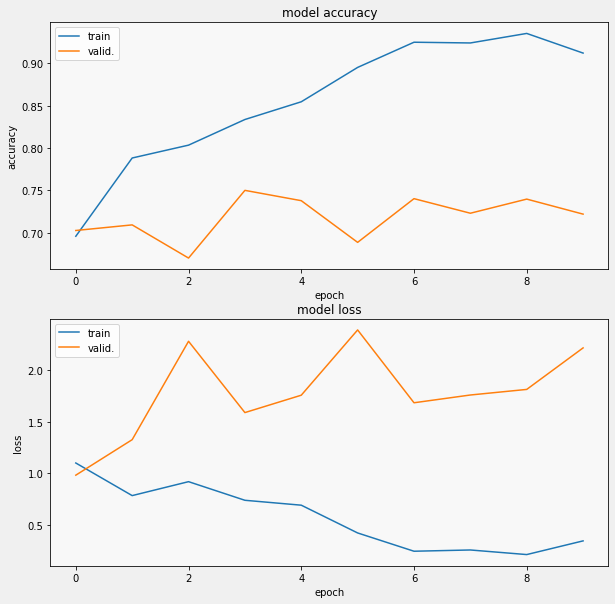

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)


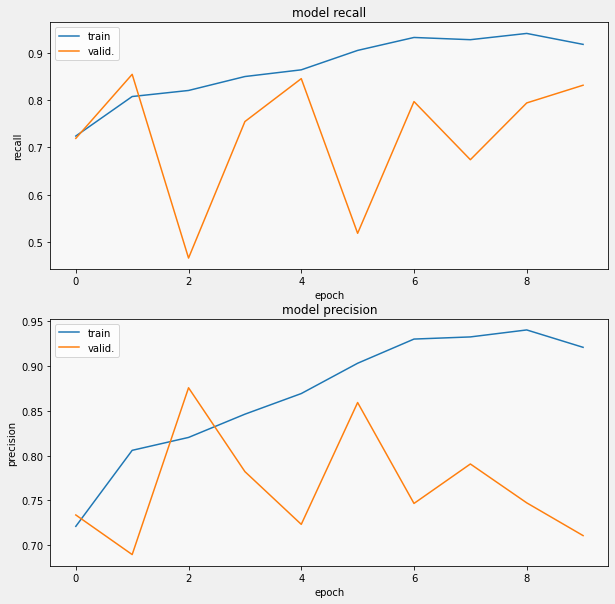

In [ ]:
display_training_curves(history.history['recall'], history.history['val_recall'], 'recall', 211)
display_training_curves(history.history['precision'], history.history['val_precision'], 'precision', 212)

#Predictions

In [ ]:
def display_9_images_with_predictions_1(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.array(list(map(lambda x : 1 if x > 0.5 else 0,predictions )))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

In [ ]:
model_pred = tf.keras.models.load_model(model_path)

In [ ]:
# random input: execute multiple times to change results
thumbnails, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

predictions = model_pred.predict(thumbnails, steps=2)
print(np.array(CLASSES)[labels].tolist())
print(np.array(CLASSES)[np.array(list(map(lambda x : 1 if x > 0.5 else 0,predictions )))].tolist())

[b'nonclickbaits', b'nonclickbaits', b'nonclickbaits', b'nonclickbaits', b'nonclickbaits', b'clickbaits', b'clickbaits', b'clickbaits', b'nonclickbaits']
[b'nonclickbaits', b'nonclickbaits', b'nonclickbaits', b'nonclickbaits', b'nonclickbaits', b'clickbaits', b'clickbaits', b'clickbaits', b'nonclickbaits']


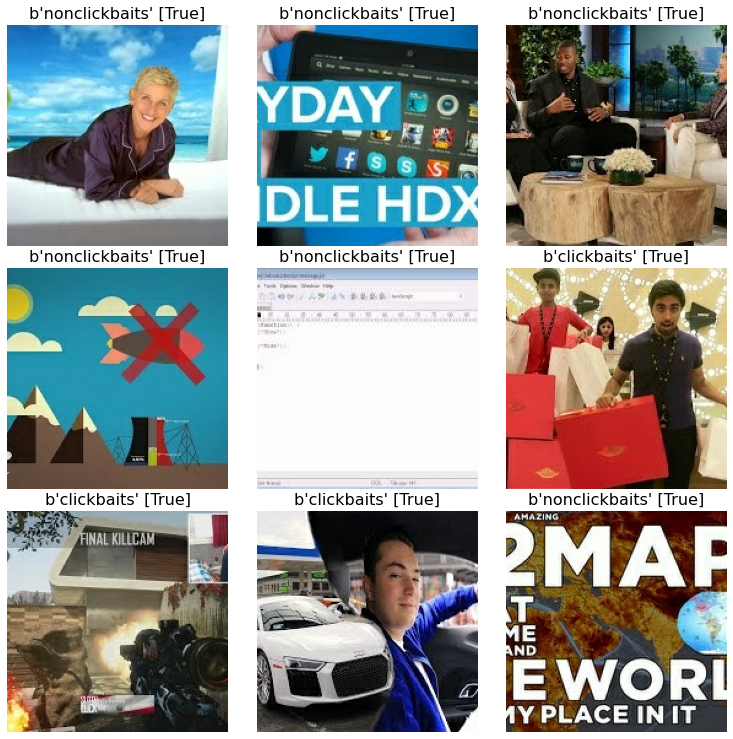

In [ ]:
display_9_images_with_predictions_1(thumbnails,predictions, labels)